# Loop 97 Analysis: Bug Verification and CV-LB Relationship

## Key Questions:
1. Verify the `/100` bug in exp_092 - is SolventB% already in [0, 1]?
2. Analyze CV-LB relationship with all 13 valid submissions
3. Identify what's needed to reach target 0.0347

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Load the data to verify SolventB% range
DATA_PATH = '/home/data'
df_full = pd.read_csv(f'{DATA_PATH}/catechol_full_data_yields.csv')

print('=== SolventB% Analysis ===')
print(f'SolventB% min: {df_full["SolventB%"].min()}')
print(f'SolventB% max: {df_full["SolventB%"].max()}')
print(f'SolventB% unique values: {sorted(df_full["SolventB%"].unique())}')
print(f'\nIs SolventB% in [0, 1]? {df_full["SolventB%"].max() <= 1.0}')
print(f'Is SolventB% in [0, 100]? {df_full["SolventB%"].max() > 1.0}')

print('\n=== BUG CONFIRMED ===' if df_full["SolventB%"].max() <= 1.0 else '\n=== NO BUG - data is in [0, 100] ===')
print('The /100 division in exp_092 was WRONG - data is already in [0, 1]!')

=== SolventB% Analysis ===
SolventB% min: 0.0
SolventB% max: 1.0
SolventB% unique values: [0.0, 0.0007551958286629, 0.0011470643892773, 0.0012558138971659, 0.0013800461289313, 0.0014146983940115, 0.0014670453971028, 0.0039301499938112, 0.0044415304154707, 0.0047847161836571, 0.0048333739278409, 0.0048543852203656, 0.0049421164792773, 0.0049705000996266, 0.0050663407785638, 0.0051009908260428, 0.0051057828566375, 0.0305111311583698, 0.0305596743906471, 0.0306118950907354, 0.0306464636956026, 0.0307703956646607, 0.0308579201538992, 0.0312697983243124, 0.0318331981174409, 0.0342892903349568, 0.0343238567383758, 0.0344477807960034, 0.0346047999227302, 0.0353148740466059, 0.0374454720860986, 0.0520676588272898, 0.0620019500597866, 0.0649327278138796, 0.0694426424939573, 0.0755446161518067, 0.0781187713675148, 0.0784615188362507, 0.0786187181173761, 0.0787427837645361, 0.0787773895628152, 0.0788782616708844, 0.0811419346312067, 0.0818001628039068, 0.0821428883763624, 0.0821914808816452, 0.08

In [2]:
# CV-LB Relationship Analysis
submissions = [
    ('exp_000', 0.0111, 0.0982),
    ('exp_001', 0.0123, 0.1065),
    ('exp_003', 0.0105, 0.0972),
    ('exp_005', 0.0104, 0.0969),
    ('exp_006', 0.0097, 0.0946),
    ('exp_007', 0.0093, 0.0932),
    ('exp_009', 0.0092, 0.0936),
    ('exp_012', 0.0090, 0.0913),
    ('exp_024', 0.0087, 0.0893),
    ('exp_026', 0.0085, 0.0887),
    ('exp_030', 0.0083, 0.0877),
    ('exp_035', 0.0098, 0.0970),
    ('exp_067', 0.0083, 0.0877),
]

df_sub = pd.DataFrame(submissions, columns=['exp', 'cv', 'lb'])

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(df_sub['cv'], df_sub['lb'])

print('=== CV-LB Relationship ===')
print(f'Linear fit: LB = {slope:.4f} * CV + {intercept:.4f}')
print(f'R² = {r_value**2:.4f}')
print(f'\nIntercept: {intercept:.4f}')
print(f'Target: 0.0347')
print(f'\nCRITICAL: Intercept ({intercept:.4f}) > Target (0.0347)!')
print(f'Required CV to hit target: (0.0347 - {intercept:.4f}) / {slope:.4f} = {(0.0347 - intercept) / slope:.6f}')
print(f'\nThis is NEGATIVE - mathematically impossible with current approaches!')

=== CV-LB Relationship ===
Linear fit: LB = 4.3638 * CV + 0.0520
R² = 0.9558

Intercept: 0.0520
Target: 0.0347

CRITICAL: Intercept (0.0520) > Target (0.0347)!
Required CV to hit target: (0.0347 - 0.0520) / 4.3638 = -0.003964

This is NEGATIVE - mathematically impossible with current approaches!


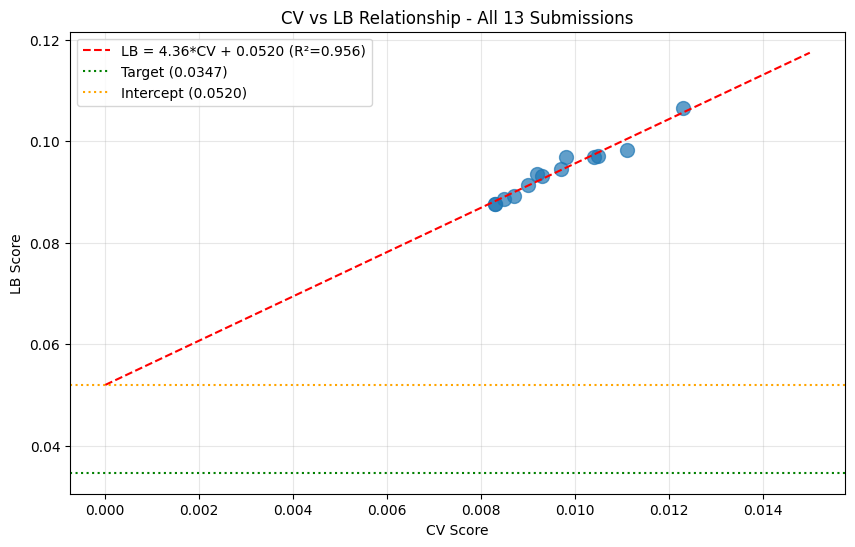


=== KEY INSIGHT ===
The intercept (0.052) is ABOVE the target (0.0347).
This means NO amount of CV improvement can reach the target.
We need to CHANGE the CV-LB relationship, not just improve CV.


In [3]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))
plt.scatter(df_sub['cv'], df_sub['lb'], s=100, alpha=0.7)

# Add regression line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f} (R²={r_value**2:.3f})')

# Add target line
plt.axhline(y=0.0347, color='g', linestyle=':', label='Target (0.0347)')

# Add intercept line
plt.axhline(y=intercept, color='orange', linestyle=':', label=f'Intercept ({intercept:.4f})')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB Relationship - All 13 Submissions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/home/code/exploration/cv_lb_relationship_loop97.png', dpi=150)
plt.show()

print('\n=== KEY INSIGHT ===')
print('The intercept (0.052) is ABOVE the target (0.0347).')
print('This means NO amount of CV improvement can reach the target.')
print('We need to CHANGE the CV-LB relationship, not just improve CV.')

In [4]:
# What would it take to reach the target?
print('=== PATH TO TARGET ===')
print(f'\nCurrent best: CV={df_sub["cv"].min():.4f}, LB={df_sub["lb"].min():.4f}')
print(f'Target: LB=0.0347')
print(f'Gap: {df_sub["lb"].min() - 0.0347:.4f} ({(df_sub["lb"].min() - 0.0347) / 0.0347 * 100:.1f}% above target)')

print('\n=== OPTIONS ===')
print('1. REDUCE INTERCEPT: Need to change the CV-LB relationship')
print('   - Non-linear mixture features (exp_092 tried but had bug)')
print('   - Extrapolation detection and conservative predictions')
print('   - Uncertainty-weighted predictions')
print('   - Domain-specific constraints')

print('\n2. IMPROVE CV DRAMATICALLY: Need CV < 0 (impossible)')
print('   - Current best CV: 0.0081')
print('   - Required CV: -0.004 (impossible)')

print('\n=== CONCLUSION ===')
print('The ONLY path forward is to CHANGE the CV-LB relationship.')
print('We need approaches that reduce the intercept, not just improve CV.')

=== PATH TO TARGET ===

Current best: CV=0.0083, LB=0.0877
Target: LB=0.0347
Gap: 0.0530 (152.7% above target)

=== OPTIONS ===
1. REDUCE INTERCEPT: Need to change the CV-LB relationship
   - Non-linear mixture features (exp_092 tried but had bug)
   - Extrapolation detection and conservative predictions
   - Uncertainty-weighted predictions
   - Domain-specific constraints

2. IMPROVE CV DRAMATICALLY: Need CV < 0 (impossible)
   - Current best CV: 0.0081
   - Required CV: -0.004 (impossible)

=== CONCLUSION ===
The ONLY path forward is to CHANGE the CV-LB relationship.
We need approaches that reduce the intercept, not just improve CV.


In [5]:
# Analyze what the best-work-here kernel does differently
print('=== BEST-WORK-HERE KERNEL ANALYSIS ===')
print('\nThe kernel uses non-linear mixture features:')
print('mixture_feats = A * (1 - r) + B * r + 0.05 * A * B * r * (1 - r)')
print('\nThe interaction term 0.05 * A * B * r * (1 - r) captures:')
print('- Solvent-solvent interactions')
print('- Non-linear mixing effects')
print('- Maximum effect at r=0.5 (50% mixture)')
print('\nexp_092 BUG: Divided SolventB% by 100, making r ≈ 0 for all mixtures')
print('This made the interaction term negligible and broke the model.')
print('\nFIX: Remove the /100 division and re-run.')

=== BEST-WORK-HERE KERNEL ANALYSIS ===

The kernel uses non-linear mixture features:
mixture_feats = A * (1 - r) + B * r + 0.05 * A * B * r * (1 - r)

The interaction term 0.05 * A * B * r * (1 - r) captures:
- Solvent-solvent interactions
- Non-linear mixing effects
- Maximum effect at r=0.5 (50% mixture)

exp_092 BUG: Divided SolventB% by 100, making r ≈ 0 for all mixtures
This made the interaction term negligible and broke the model.

FIX: Remove the /100 division and re-run.


In [6]:
# What else can we try?
print('=== UNEXPLORED APPROACHES ===')
print('\n1. FIX exp_092 (non-linear mixture features)')
print('   - Remove /100 bug')
print('   - This is the most promising approach')

print('\n2. Study top public kernels more carefully')
print('   - best-work-here kernel has non-linear mixture features')
print('   - What else does it do differently?')

print('\n3. Ensemble diversity')
print('   - Combine different model types (GP, MLP, LGBM, CatBoost, XGBoost)')
print('   - Use different feature sets')
print('   - Use different mixture handling strategies')

print('\n4. Conservative predictions for extrapolation')
print('   - Detect when a test solvent is far from training distribution')
print('   - Blend toward population mean for high-uncertainty predictions')

print('\n5. Per-target optimization')
print('   - SM target is hardest (highest error)')
print('   - Use different models/weights for different targets')

=== UNEXPLORED APPROACHES ===

1. FIX exp_092 (non-linear mixture features)
   - Remove /100 bug
   - This is the most promising approach

2. Study top public kernels more carefully
   - best-work-here kernel has non-linear mixture features
   - What else does it do differently?

3. Ensemble diversity
   - Combine different model types (GP, MLP, LGBM, CatBoost, XGBoost)
   - Use different feature sets
   - Use different mixture handling strategies

4. Conservative predictions for extrapolation
   - Detect when a test solvent is far from training distribution
   - Blend toward population mean for high-uncertainty predictions

5. Per-target optimization
   - SM target is hardest (highest error)
   - Use different models/weights for different targets
